# Mass Map around Abell 360

Anthony Englert\
LSST Science Piplines version: Weekly 2025_09\
Container Size: large

This notebook is a first attempt at building a mass map of Abell 360 cluster from ComCam data, with the following main steps:

- Loading the relevant object catalogs (all tracts and patches needed) using the butler
- Color cut source selection
- HSC lensing quality cuts
- HSC calibration step. You will need to run the `gen_hsc_calibration` script outside of this notebook. The script is publicly available at: [https://github.com/PrincetonUniversity/hsc-y1-shear-calib](https://github.com/PrincetonUniversity/hsc-y1-shear-calib)
- Computing mass map from calibrated shapes

The first portion of this borrows from Celine's script to select galaxies redder than the red-sequence, then uses code developed for the Local Volume Complete Cluster Survey to compute the mass map

In [1]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table

In [2]:
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom

In [3]:
repo = "dp1"
collection = "LSSTComCam/DP1"
#repo = '/repo/main'
#collection = 'LSSTComCam/runs/DRP/DP1/w_2025_08/DM-49029'

butler = Butler(repo, collections=collection)
assert butler is not None

In [4]:
skymap = butler.get('skyMap', skymap='lsst_cells_v1')

## Find tracts and patches for Abell 360 and load the catalogs

Find all the tracts/patches that falls in a given region around the A360 BCG, and store the results in a dictionary `tp_dict`

In [5]:
# Position of the BCG for A360
ra_bcg = 37.862
dec_bcg = 6.98

# Looking for all patches in delta deg region around it
delta = 0.5
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

tracts_and_patches = skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
#tp_dict

Load the object catalogs for all these tracts/patches, make basic cuts, and store in a single merged catalog `merged_cat`.

In [6]:
# Get the object catalog of these patches
datasetType = 'object'  # for DP1 object catalogs
#datasetType = 'objectTable'
#datasetType = 'deepCoadd_obj'
merged_cat = pd.DataFrame()

for tract in tp_dict.keys():
    print(f'Loading objects from tract {tract}, patches:{tp_dict[tract]}')
    for patch in tp_dict[tract]:
        dataId = {'tract': tract, 'patch' : patch ,'skymap':'lsst_cells_v1'}
        print(f"Filtered patch {patch} in tract {tract}")
        obj_cat = butler.get(datasetType, dataId=dataId)
        # obj_cat is an astropy Table in DP1. Convert to DataFrame if needed for consistent processing
        if isinstance(obj_cat, Table):
            obj_cat = obj_cat.to_pandas()
        elif not isinstance(obj_cat, pd.DataFrame):
            raise TypeError(f"Unexpected object type: {type(obj_cat)}")

        # 'detect_isPrimary' not in DP1; 
        # only 'detect_fromBlend', 'detect_isDeblendedModelSource', 'detect_isIsolated' exist
        #filt = obj_cat['detect_isPrimary']==True 

        # try only loading he essential columns
        column_list = [
                       'objectId','tract','patch','coord_ra','coord_dec',
                       'r_cModel_flag','i_cModel_flag','refExtendedness','i_iPSF_flag',
                       'i_cModelFlux','i_cModelFluxErr',
                       'g_cModelFlux','g_cModelFluxErr',
                       'r_cModelFlux','r_cModelFluxErr',
                       'z_cModelFlux','z_cModelFluxErr',
                       'i_ixxPSF','i_iyyPSF','i_ixyPSF','i_ixx','i_iyy','i_ixy',
                       'i_hsmShapeRegauss_e1','i_hsmShapeRegauss_e2','i_hsmShapeRegauss_sigma',
                       'i_hsmShapeRegauss_flag','i_blendedness',
                      ]
        
        obj_cat = obj_cat[column_list]
        
        filt = obj_cat['r_cModel_flag']== False
        filt &= obj_cat['i_cModel_flag']== False
        filt &= obj_cat['r_cModelFlux']>0
        filt &= obj_cat['i_cModelFlux']>0
        filt &= obj_cat['refExtendedness'] > 0.5
        
        merged_cat = pd.concat([merged_cat, obj_cat[filt]], ignore_index=True)

Loading objects from tract 10463, patches:[30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94]
Filtered patch 30 in tract 10463
Filtered patch 40 in tract 10463
Filtered patch 50 in tract 10463
Filtered patch 60 in tract 10463
Filtered patch 70 in tract 10463
Filtered patch 80 in tract 10463
Filtered patch 90 in tract 10463
Filtered patch 31 in tract 10463
Filtered patch 41 in tract 10463
Filtered patch 51 in tract 10463
Filtered patch 61 in tract 10463
Filtered patch 71 in tract 10463
Filtered patch 81 in tract 10463
Filtered patch 91 in tract 10463
Filtered patch 32 in tract 10463
Filtered patch 42 in tract 10463
Filtered patch 52 in tract 10463
Filtered patch 62 in tract 10463
Filtered patch 72 in tract 10463
Filtered patch 82 in tract 10463
Filtered patch 92 in tract 10463
Filtered patch 33 in tract 10463
Filtered patch 43 in tract 10463
Filtered patch 53 in tract 10463
Filtered patch 63 in trac

In [23]:
'objectId' in list(merged_cat.columns)

True

## Red sequence identification

### Select a circular field close (<0.1 deg) to the BCG in order to identify RS

In [7]:
import astropy.units as u
from astropy.coordinates import SkyCoord

c1 = SkyCoord(merged_cat['coord_ra'].values*u.deg, merged_cat['coord_dec'].values*u.deg)
c2 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
sep = c1.separation(c2)

sep.deg
filt = sep.deg < 0.1 # stay close to cluster center for RS indentification
merged_cat_rs = merged_cat[filt] # catalog for RS identification

In [8]:
len(merged_cat), len(merged_cat_rs)

(8114925, 152145)

### Convert fluxes to magnitudes and identify red sequence in r-i versus r

Conversion from fluxes to mag using formula from DP0.2 tutorial.

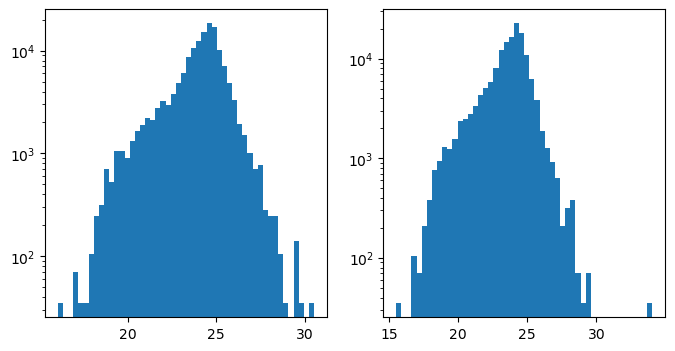

In [9]:
mag_i = -2.50 * np.log10(merged_cat_rs['i_cModelFlux']) + 31.4
mag_r = -2.50 * np.log10(merged_cat_rs['r_cModelFlux']) + 31.4

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].hist(mag_r, bins=50)
ax[1].hist(mag_i, bins=50)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

### Color magnitude diagram and by eye indetification of the red sequence


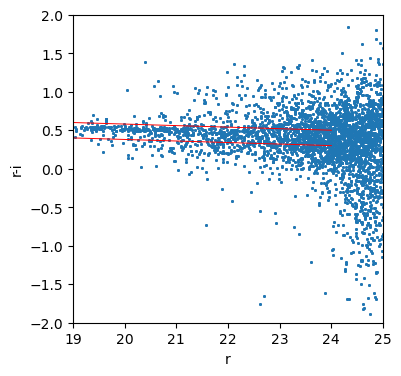

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(mag_r, mag_r-mag_i, marker='.', s=0.3)
ax.set_ylim([-2,2])
ax.set_xlim([19,25])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
ax.plot([19,24],[0.4,0.3], color='r', linewidth=0.7)
ax.plot([19,24],[0.6,0.5], color='r', linewidth=0.7)

### Filter to identify red sequence galaxies in the sample


In [11]:
rs_hi = 0.6 - (0.1/5.) * (mag_r-19)
rs_low = 0.4 - (0.1/5.)* (mag_r-19)
color = mag_r - mag_i

idx = np.where(np.logical_and(color>rs_low, color<rs_hi))[0]
idx2 = np.where(mag_r.iloc[idx] < 23)[0] # keep the brightest objects only

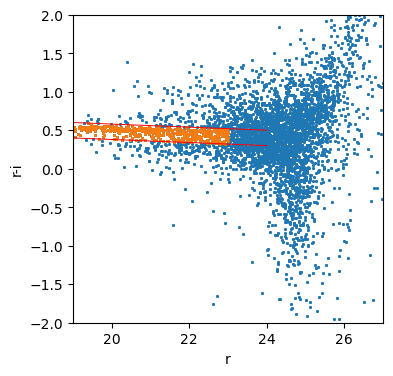

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(mag_r, mag_r-mag_i, marker='.', s=0.3) # all galaxies  
ax.scatter(mag_r.iloc[idx].iloc[idx2], 
           mag_r.iloc[idx].iloc[idx2]-mag_i.iloc[idx].iloc[idx2], 
           marker='.', s=0.3) #red sequence galaxies
ax.set_ylim([-2,2])
ax.set_xlim([19,27])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
ax.plot([19,24],[0.4,0.3], color='r', linewidth=0.7)
ax.plot([19,24],[0.6,0.5], color='r', linewidth=0.7)

## Remove red sequence galaxies in the full field

For the analysis, we'll keep source galaxies within 0.5 deg from the BCG. Now we apply the RS cut defined on the small region above to the full field of the analysis. The RS-free catalog is stored as `merged_cat_wl`. The lensing quality cuts will be performed in a subsequent step. 

In [13]:
filt = sep.deg < 0.5 # larger field for analysis
merged_cat_wl = merged_cat[filt]

In [14]:
mag_i = -2.50 * np.log10(merged_cat_wl['i_cModelFlux']) + 31.4
mag_r = -2.50 * np.log10(merged_cat_wl['r_cModelFlux']) + 31.4
color = mag_r - mag_i

# Filter defined above applied to the full sample
rs_hi = 0.6 - (0.1/5.) * (mag_r-19)
rs_low = 0.4 - (0.1/5.)* (mag_r-19)

idx = np.where(np.logical_and(color>rs_low, color<rs_hi))[0]
idx2 = np.where(mag_r.iloc[idx] < 23)[0] # keep the brightest objects only

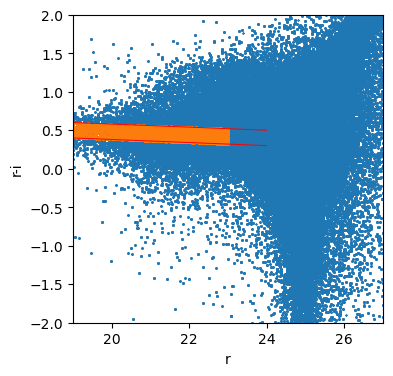

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(mag_r, mag_r-mag_i, marker='.', s=0.3) # all galaxies  
ax.scatter(mag_r.iloc[idx].iloc[idx2], 
           mag_r.iloc[idx].iloc[idx2]-mag_i.iloc[idx].iloc[idx2], 
           marker='.', s=0.3) #red sequence galaxies
ax.set_ylim([-2,2])
ax.set_xlim([19,27])
ax.set_ylabel('r-i')
ax.set_xlabel('r')
ax.plot([19,24],[0.4,0.3], color='r', linewidth=0.7)
ax.plot([19,24],[0.6,0.5], color='r', linewidth=0.7)

In [16]:
RS_id_list = merged_cat_wl['objectId'].iloc[idx].iloc[idx2]

In [17]:
len(RS_id_list)

157700

In [18]:
# Filter out rows where the 'dataid' column matches any value in RS_id_list
merged_cat_wl = merged_cat_wl[~merged_cat_wl['objectId'].isin(RS_id_list)]

## Lensing cuts

The RS sequence has been removed. Now apply a series of lensing cuts (mostly following Shenming's [CLMM HSC demo analysis](https://github.com/LSSTDESC/CLMM/blob/main/examples/mass_fitting/Example4_Fit_Halo_mass_to_HSC_data.ipynb), but missing some at the moment), to the `merged_cat_wl` catalog. There might be more cuts to implement to improve sample purity.

In [19]:
len(merged_cat_wl)

3331093

In [20]:
# Compute again magnitudes, but for the RS-free catalog
mag_i = -2.50 * np.log10(merged_cat_wl['i_cModelFlux']) + 31.4
mag_r = -2.50 * np.log10(merged_cat_wl['r_cModelFlux']) + 31.4

# Filters to keep sources with good-quality measured shape in i band
source_filt = np.isfinite(merged_cat_wl['i_hsmShapeRegauss_e1'])
source_filt &= np.isfinite(merged_cat_wl['i_hsmShapeRegauss_e2'])
source_filt &= np.sqrt(merged_cat_wl['i_hsmShapeRegauss_e1']**2 + merged_cat_wl['i_hsmShapeRegauss_e2']**2) < 4
source_filt &= merged_cat_wl['i_hsmShapeRegauss_sigma']<= 0.4 
source_filt &= merged_cat_wl['i_hsmShapeRegauss_flag'] == 0
source_filt &= merged_cat_wl['i_blendedness'] < 0.42
source_filt &= merged_cat_wl['i_iPSF_flag']==0

# Resolution factor quality cut - according to Mandelbaum (2018) paper:
# "we use the resolution factor R2 which is defined using the trace of the moment matrix of the PSF TP and 
# of the observed (PSF-convolved) galaxy image TI as: R2 = 1- TP/TI"
# Best guess to translate that in terms of ComCam objectTable catalog output...

res = 1 - (merged_cat_wl['i_ixxPSF']+ merged_cat_wl['i_iyyPSF']) / (merged_cat_wl['i_ixx']+ merged_cat_wl['i_iyy'])
source_filt &= res >= 0.3

# NB: Resolution needs to be double checked. As pointed out by Anthony, 
# the 'ext_shapeHSM_HsmShapeRegauss_resolution' column exists in 
# the deepCoadd_obj 'meas' table  but not in the objectTable table. Would need a match between the two to
# pull the resolution directly from the meas table rather than recomputing it here (comparing the two 
# would be a good check of whether the formula below is the right one to use). To be done/investigated.

source_filt &= mag_i <= 24.5
#source_filt &= mag_i > 20. # to remove the brightest objects that are likely foreground objects

print(f'Source sample size: {np.sum(source_filt)}')

Source sample size: 764266


### Final source sample CMD, (ra,dec) distribution, etc.

Text(0.5, 0, 'r')

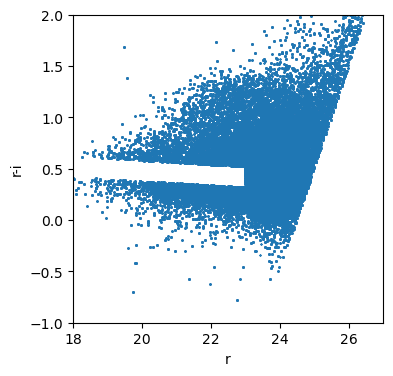

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, 
                         figsize=(4,4))
ax.scatter(mag_r[source_filt], mag_r[source_filt]-mag_i[source_filt], marker='.', s=0.3) # all galaxies  
ax.set_ylim([-1,2])
ax.set_xlim([18,27])
ax.set_ylabel('r-i')
ax.set_xlabel('r')

In [22]:
ra = merged_cat_wl['coord_ra'][source_filt]
dec = merged_cat_wl['coord_dec'][source_filt]
e1 = merged_cat_wl['i_hsmShapeRegauss_e1'][source_filt]
e2 = merged_cat_wl['i_hsmShapeRegauss_e2'][source_filt]
e_err = merged_cat_wl['i_hsmShapeRegauss_sigma'][source_filt]

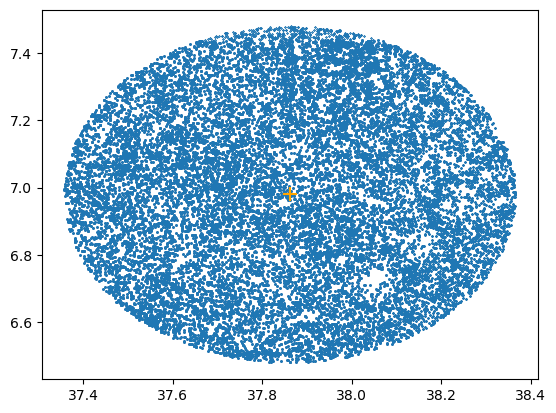

In [23]:
plt.scatter(ra, dec, marker='.', s=0.2)
plt.scatter([ra_bcg], [dec_bcg], marker='+', s=100, color='orange')

## Apply HSC shear calibration

### Save source catalog `merged_cat_wl` as fits file to use as input for the HSC calibration script.

In [24]:
from astropy.io import fits
from astropy.table import Table, vstack
import pandas as pd

# Too many columns in the pandas dataframe. Remove some unecessary ones.
import re
# Define pattern (example: drop all columns starting with "temp_")
pattern = r"^g_|^z_"  
# Drop columns matching the pattern
merged_cat_wl = merged_cat_wl.drop(columns=[col for col in merged_cat_wl.columns if re.match(pattern, col)])

astropy_table = Table.from_pandas(merged_cat_wl[source_filt])
astropy_table.write('source_sample.fits', format="fits", overwrite=True)

Now that the source_sample.fits file exists, need to use the HSC calibration in the command line. The `get_snr, get_res, get_psf_ellip` functions in the `utilities.py` file from the HSC calibration repo first need to be updated to use the column names of DP1. Then run:
```
python gen_hsc_calibrations.py source_sample.fits source_sample_calib.fits
```
which will create the `source_sample_calib.fits` file that is read below.

### Read in the calibration quantities and apply the calibration

In [25]:
from astropy.io import fits
from astropy.table import Table, vstack
import pandas as pd

with fits.open('source_sample_calib.fits') as hdul:
    # Assuming data is in the first HDU (if not, change the index as needed)
    data = hdul[1].data

    # Convert the FITS data to an Astropy Table
    table = Table(data)

e_rms = table["ishape_hsm_regauss_derived_rms_e"]
m = table["ishape_hsm_regauss_derived_shear_bias_m"]
c1 = table["ishape_hsm_regauss_derived_shear_bias_c1"]
c2 = table["ishape_hsm_regauss_derived_shear_bias_c2"]
weight = table["ishape_hsm_regauss_derived_shape_weight"]

to_use = np.isfinite(weight)*np.isfinite(e_rms)*np.isfinite(m)*np.isfinite(c1)*np.isfinite(c2)

e1_0 = e1[to_use]
e2_0 = e2[to_use]
e_rms = e_rms[to_use]
c1 = c1[to_use]
c2 = c2[to_use]
m = m[to_use]
weight = weight[to_use]

print(f'Number of sources with calibration: {np.sum(to_use)}')

Number of sources with calibration: 764266


In [26]:
# From Shenming's CLMM demo on using HSC data
def apply_shear_calibration(e1_0, e2_0, e_rms, m, c1, c2, weight):
    R = 1.0 - np.sum(weight * e_rms**2.0) / np.sum(weight)
    m_mean = np.sum(weight * m) / np.sum(weight)
    c1_mean = np.sum(weight * c1) / np.sum(weight)
    c2_mean = np.sum(weight * c2) / np.sum(weight)
    print("R, m_mean, c1_mean, c2_mean: ", R, m_mean, c1_mean, c2_mean)

    g1 = (e1_0 / (2.0 * R) - c1) / (1.0 + m_mean)
    g2 = (e2_0 / (2.0 * R) - c2) / (1.0 + m_mean)

    return g1, g2

In [27]:
g1, g2 = apply_shear_calibration(e1_0, e2_0, e_rms, m, c1, c2, weight)

R, m_mean, c1_mean, c2_mean:  0.840546104715675 -0.2667317649344134 -0.0007951414865831405 -7.599909516437531e-05


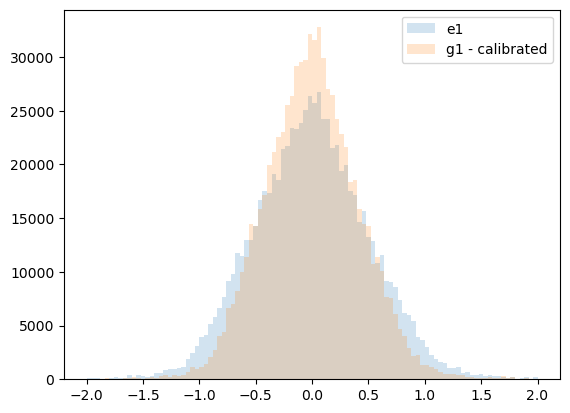

In [28]:
plt.hist(e1[to_use], bins=100, alpha=0.2, range=[-2, 2], label='e1');
plt.hist(g1, bins=100, alpha=0.2,range=[-2, 2], label='g1 - calibrated');
plt.legend()

## Mass Aperture Statistics

Mass aperture statistics are one way of mapping the distribution of dark matter across a cluster, it's an integral statistic which convolves the observed shears with a filter optimized to match a given profile. For LoVoCCS (which I'll borrow here), we normally use a 'Schirmer filter' (Schirmer+04, Hetterscheidt+05, Schirmer+06, McCleary+18, Fu+22, Fu+24)

In [121]:
def schirmer_filter(radius,aperture_size=8000,x_cut=0.15,a=6,b=150,c=47,d=50,*_):
    '''
    The Schirmer Filter, a filter which is optimized for detecting NFW-like structures in shear-fields.
    
    Args:
        radius: Numpy array; an array of radii to evaluate the filter on
        aperture_size: float-like; the 'schirmer-radius' of the filter
        x_cut: float-like; specifies the filter-sloap and sets the characteristic-scale of the filter to x_cut*smoothing
    
    Returns:
        Q; Numpy array; an array containing the filter evaluated at each radius
    
    '''
    
    x = radius/aperture_size
    Q = ( 1/( 1 + np.exp(a - b*x) + np.exp(-c + d*x)) )*( np.tanh(x/x_cut)/(x/x_cut) )
    return Q

For the time being, I'll write this to work on a flat-sky approximation since we're only dealing with a ~0.5deg cutout surrounding the cluster. This uses a direct estimator for the aperture mass statistic at each point and evaluates it on a series of "grid-points" specified by the user

In [122]:
def compute_mass_map(x_grid,y_grid,x,y,g1,g2,weights,q_filter,filter_kwargs={}):
    '''
    This function computes the mass aperture-statistics at each point on a specified grid. Run quality-cuts, NaN filtering, etc. before this step!
    
    Args:
        x: Numpy array; an array of x-coordinates for each object
        y: Numpy array; an array of y-coordinates for each object
        x_grid: Numpy array; an NxM array of x-coordinates to sample the aperture-mass on
        y_grid: Numpy array; an NxM array of y-coordinates to sample the aperture-mass on
        g1; Numpy array; the shear g1 for each object
        g2; Numpy array; the shear g2 for each object
        weights: Numpy array; the weight for each object's shear
        q_filter; function; the filter-function used to compute Map
        kwargs; dict; kwargs passed to w_filter
    
    Returns:
        Map_E: Numpy array; an NxM array containing the E-mode aperture mass evaluated at each grid-point
        Map_B: Numpy array; an NxM array containing the B-mode aperture mass evaluated at each grid-point
        Map_V: Numpy array; an NxM array containing the variance in the aperture mass evaluated at each grid-point

    '''

    y_shape = len(y_grid[:,0])
    x_shape = len(x_grid[0,:])
    
    Map_E = np.zeros((y_shape,x_shape))
    Map_B = np.zeros((y_shape,x_shape))
    Map_V = np.zeros((y_shape,x_shape))
    
    if 'aperture_size' not in filter_kwargs:
        filter_area = np.pi * (8000)**2
    else:
        filter_area = np.pi * filter_kwargs['aperture_size']**2
    
    # an extra catch for an objects assigned NaN g1/g2 just in case
    nan_catch = np.isfinite(g1) & np.isfinite(g2)
    x = x[nan_catch]
    y = y[nan_catch]
    g1 = g1[nan_catch]
    g2 = g2[nan_catch]
    weights = weights[nan_catch]
    
    for i in range(y_shape):
        for j in range(x_shape):
            delta_x = x_grid[j,i] - x
            delta_y = y_grid[j,i] - y
            radius = np.sqrt(delta_x**2 + delta_y**2)
            theta = np.arctan2(delta_y,delta_x)
            g_T = -g1*np.cos(2*theta) - g2*np.sin(2*theta)
            g_X =  g1*np.sin(2*theta) - g2*np.cos(2*theta)
            g_mag = g1**2 + g2**2
            
            filter_values = q_filter(radius,**filter_kwargs)

            weight_sum = np.sum(weights)
            
            Map_E[i,j] = np.sum(filter_values*g_T*weights)*filter_area/weight_sum
            Map_B[i,j] = np.sum(filter_values*g_X*weights)*filter_area/weight_sum
            Map_V[i,j] = np.sum( (filter_values**2)*g_mag*(weights**2) )*(filter_area**2)/(2*(weight_sum**2))
            
    return Map_E, Map_B, Map_V

Let's define a grid of x and y coordinates from the catalog of selected galaxies

In [141]:
# first, setup a coordinates for a flat-sky in x and y
# create a WCS and use the corresponding method to transform sky to px coords

# load wcs from astropy
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

# also load skycoord for the conversion
from astropy.coordinates import SkyCoord

# build wcs centered on BCG
flat_wcs = WCS(naxis=2)
crval_sky = [ra_bcg*u.deg,dec_bcg*u.deg]
flat_wcs.wcs.crval = [ra_bcg,dec_bcg]
flat_wcs.wcs.crpix = [0,0] # assign 0,0 to the center, shouldn't matter
flat_wcs.wcs.cdelt = [-0.2/3600,0.2/3600] # match angular resolution of LSST, 0.2"
flat_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
flat_wcs.wcs.radesys = 'ICRS'
flat_wcs.wcs.equinox = 2000
flat_wcs.wcs.cd = [[-0.2/3600,0],[0,0.2/3600]]

# compute coords in the flat-sky
coords = SkyCoord(ra=merged_cat_wl['coord_ra'][source_filt][to_use],dec=merged_cat_wl['coord_dec'][source_filt][to_use],unit='degree')
x,y = skycoord_to_pixel(coords,wcs=flat_wcs)

# scale these up to units of degrees to match mass_map spacing and make writing the aperture easier
x = x * 0.2/3600
y = y * 0.2/3600

In [153]:
# for now I'll weight everything uniformly
weights = weight #np.ones(len(x))

# Define an NxN grid centered on the cluster
# Spans 1-deg centered at the BCG
# scale so that its in pixel coordinates for computing
N = 31

mid_x = 0
mid_y = 0
x_grid_samples = np.linspace(mid_x-0.5,mid_x+0.5,N)
y_grid_samples = np.linspace(mid_y-0.5,mid_y+0.5,N)
y_grid,x_grid = np.meshgrid(y_grid_samples,x_grid_samples)

Define a WCS for this grid

In [154]:
# load wcs from astropy
from astropy.wcs import WCS

# build wcs centered on BCG
Map_wcs = WCS(naxis=2)
crval_sky = [ra_bcg*u.deg,dec_bcg*u.deg]
Map_wcs.wcs.crval = [ra_bcg,dec_bcg]
Map_wcs.wcs.crpix = [0,0]
Map_wcs.wcs.cdelt = [-1/N,1/N]
Map_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
Map_wcs.wcs.radesys = 'ICRS'
Map_wcs.wcs.equinox = 2000
Map_wcs.wcs.cd = [[-1/N,0],[0,1/N]]

In [155]:
# this takes a minute to run
e_ap,b_ap,v_ap = compute_mass_map(x_grid,y_grid,x,y,g1,g2,weights,schirmer_filter,filter_kwargs={'aperture_size':0.6})

Now we're all set to compute the MassMap

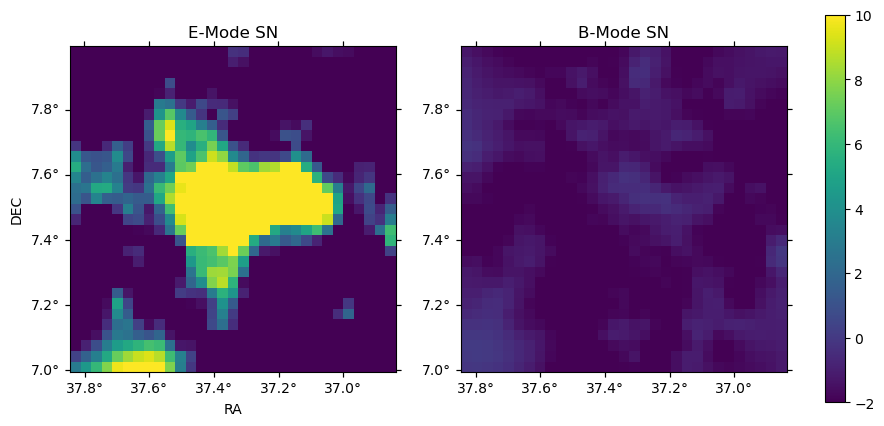

In [156]:
fig, axs = plt.subplots(ncols=2,subplot_kw=dict(projection=Map_wcs),figsize=(10,6))

ax = axs[0]
ax.set_title('E-Mode SN')
MapE = ax.imshow(e_ap/np.sqrt(v_ap),origin='lower',vmax=10,vmin=-2)

lon = ax.coords[0]
lat = ax.coords[1]

lon.set_major_formatter('d.d')
lat.set_major_formatter('d.d')
lon.set_axislabel('RA')
lat.set_axislabel('DEC')

ax = axs[1]
ax.set_title('B-Mode SN')
MapB = ax.imshow(b_ap/np.sqrt(v_ap),origin='lower',vmax=100,vmin=-2)

lon = ax.coords[0]
lat = ax.coords[1]

lon.set_major_formatter('d.d')
lat.set_major_formatter('d.d')
lon.set_axislabel('')
lat.set_axislabel('')

cbar = fig.colorbar(MapE, ax=axs,fraction=0.025)

#fig.savefig('ACO360_mass_map.png',dpi=480)
# woohoo, we have a signal!

array([[1.12113347e-66, 1.51238335e-51, 4.62830068e-37, 1.66814392e-24,
        3.11134813e-15, 2.42733759e-14, 8.06811433e-14, 1.73817746e-13,
        3.03916952e-13, 3.67535756e-13, 2.81389766e-13, 3.20662989e-13,
        3.41491826e-13, 2.09836696e-13, 9.56996795e-14, 2.74441854e-14,
        2.55327367e-15, 5.06783943e-23, 3.89486328e-37, 1.22255597e-50,
        5.26003641e-66],
       [2.39390257e-52, 1.13425063e-35, 1.17508906e-20, 8.27516343e-15,
        4.99280385e-14, 2.06579697e-13, 4.60885672e-13, 7.50069477e-13,
        8.24628334e-13, 7.29775876e-13, 6.50637309e-13, 7.21950385e-13,
        6.43744158e-13, 6.83200592e-13, 4.48140325e-13, 1.94207885e-13,
        8.51392986e-14, 2.35977940e-14, 1.43609903e-19, 4.74763801e-35,
        7.16076981e-51],
       [5.72002411e-37, 1.69047623e-21, 1.36319523e-14, 6.36253975e-14,
        2.11978274e-13, 5.31158793e-13, 9.72883756e-13, 8.35373564e-13,
        9.13570055e-13, 9.38684561e-13, 7.36153675e-13, 6.46349450e-13,
        7.3302